## 0. 모듈 임포트
-----

In [93]:
import glob, os, re
import tensorflow as tf
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

## 1. 데이터 읽어오기
-----

In [66]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:7])

데이터 크기: 187088
Examples:
 ['I hear you callin\', "Here I come baby"', 'To save you, oh oh', "Baby no more stallin'", 'These hands have been longing to touch you baby', "And now that you've come around, to seein' it my way", "You won't regret it baby, and you surely won't forget it baby", "It's unbelieveable how your body's calling for me"]


## 2. 데이터 정제
-----

In [67]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


#### 조건 1.  토큰 개수가 15개 이상이 되면 제외한다.

In [68]:
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15:
        continue
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]
len(corpus)

156013

### 토큰생성
#### 조건 2-1. 단어장 크기 12000 이상

In [113]:
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2   4 186 ...   0   0   0]
 [  2  10 588 ...   0   0   0]
 [  2  52  42 ...   0   0   0]
 ...
 [  2   4  92 ...   0   0   0]
 [  2   9 156 ...   0   0   0]
 [  2 178  16 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f8071648c50>


In [75]:
print(len(tensor))

156013


In [76]:
# 열길이 14로 변환
tensor = tensor[:,:15]
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]

print(f'src_input count:{len(src_input)}')
print(src_input[0])
print(f'tgt_input count:{len(tgt_input)}')
print(tgt_input[0])

src_input count:156013
[  2   4 186   7 838   5  90   4  68  52   3   0   0   0]
tgt_input count:156013
[  4 186   7 838   5  90   4  68  52   3   0   0   0   0]


## 4. 평가 데이터셋 분리
-----


#### 조건 2-2. 총 데이터의 20%를 평가데이터 셋으로 사용

In [77]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input,test_size=0.2)

print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (124810, 14)
Target Train: (124810, 14)


## 5. 인공지능 만들기
-----

### 학습모델  'lyricist' 생성

In [91]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size, name='lyricist')
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

### lyricist가 훈련데이터 학습

In [95]:
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

lyricist.compile(optimizer='adam', loss=loss)

lyricist_hist = lyricist.fit(enc_train, dec_train, epochs=10)

Epoch 1/10
3901/3901 [==============================] - 338s 86ms/step - loss: 3.1941
Epoch 2/10
3901/3901 [==============================] - 334s 86ms/step - loss: 2.6890
Epoch 3/10
3901/3901 [==============================] - 334s 86ms/step - loss: 2.3695
Epoch 4/10
3901/3901 [==============================] - 334s 86ms/step - loss: 2.0879
Epoch 5/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.8565
Epoch 6/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.6549
Epoch 7/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.4943
Epoch 8/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.3683
Epoch 9/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.2643
Epoch 10/10
3901/3901 [==============================] - 334s 86ms/step - loss: 1.1852


### 학습 과정의 loss와 accuracy 시각화
* [케라스 기초 - JuHyang](https://ju-hyang.tistory.com/28)를 참조하였다.

In [134]:
print(lyricist_hist.history)

{'loss': [3.035079002380371, 2.6507110595703125, 2.3541369438171387, 2.091452121734619, 1.8688610792160034, 1.6806141138076782, 1.5244412422180176, 1.3982229232788086, 1.2984201908111572, 1.2194125652313232]}


AttributeError: 'History' object has no attribute 'histroy'

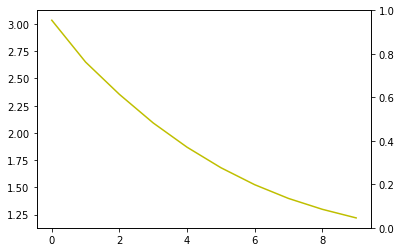

In [118]:
%matplotlib inline

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(lyricist_hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(lyricist_hist.history['val_loss'],'r',label='val loss')

acc_ax.plot(lyricist_hist.histroy['acc'], 'b', label='train acc')
#acc_ax.plot(lyricist_hist.histroy['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
accax.set_ylabel('accuracy')

loss_ax.legned(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### lyricist 모델 요약

In [103]:
lyricist.summary()

Model: "text_generator_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  3840256   
_________________________________________________________________
lstm_8 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_9 (LSTM)                multiple                  8392704   
_________________________________________________________________
lyricist (Dense)             multiple                  15376025  
Total params: 32,855,961
Trainable params: 32,855,961
Non-trainable params: 0
_________________________________________________________________


### lylicist 가사생성 함수

In [121]:
def generate_text(lyricist, tokenizer, init_sentence="<start>", max_len=14):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = lyricist(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

### lylicist 데뷔 

In [135]:
generate_text(lyricist, tokenizer, init_sentence="<start> you")

'<start> you know i m never gonna leave you <end> '